In this notebook, I want to focus on the trajectory clip that darting behaviors happen frequently.

In [1]:
import sys
sys.path.append('/Users/leah/Columbia/courses/19summer/SocialBehavior/SocialBehaviorptc')

In [19]:
from socialbehavior.models.hmm import HMM
from socialbehavior.observations.ar_sigmoid_normal_observation import ARSigmoidNormalObservation
from socialbehavior.distributions.sigmoidnormal import SigmoidNormal
from socialbehavior.transformations.linear import LinearTransformation
from socialbehavior.utils import find_permutation, random_rotation, k_step_prediction

import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

from hips.plotting.colormaps import gradient_cmap, white_to_color_cmap
color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

from tqdm import tqdm_notebook as tqdm
import sys
import time

from IPython.display import HTML

In [3]:
import joblib

datasets_processed = joblib.load('/Users/leah/Columbia/courses/19summer/SocialBehavior/tracedata/all_data_3_1')  # a list of length 30, each is a social_dataset

rendered_data = []
for dataset in datasets_processed:
    session_data = dataset.render_trajectories([3,8])  # list of length 2, each item is an array (T, 2). T = 36000
    rendered_data.append(np.concatenate((session_data),axis = 1)) # each item is an array (T, 4)
trajectories = np.concatenate(rendered_data,axis = 0)  # (T*30, 4)

traj29 = rendered_data[29]

In [4]:
arena_xmax = 320
arena_ymax = 370

In [5]:
K = 5
D = 4
T = 36000

bounds = np.array([[-10, arena_xmax + 10], [-10, arena_ymax + 10], [-10, arena_xmax + 10],
                   [-10, arena_ymax + 10]])

#bounds = np.array([[-300, 300], [-300, 300], [-300, 300], [-300, 300]])

In [6]:
def plot_2_mice(data):
    plt.plot(data[:,0], data[:,1], label='virgin')
    plt.plot(data[:,2], data[:,3], label='mother')
    plt.legend();

In [7]:
def plot_4_traces(data):
    plt.plot(data[:, 0], label='x1')
    plt.plot(data[:, 1], label='y1')
    plt.plot(data[:, 2], label='x2')
    plt.plot(data[:, 3], label='y2')
    plt.legend();

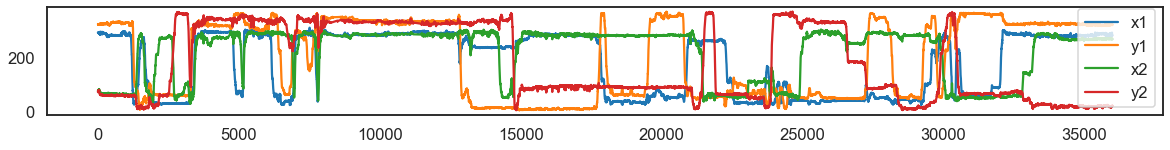

In [9]:
plt.figure(figsize=(20,2))
plot_4_traces(traj29)

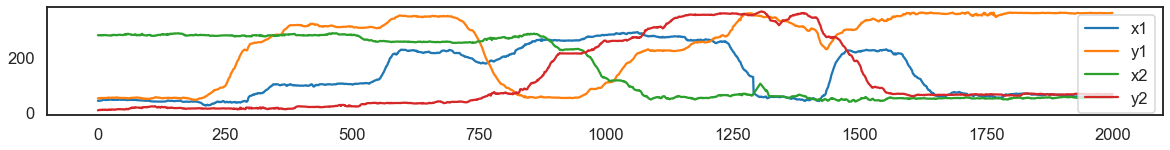

In [25]:
plt.figure(figsize=(20,2))
plot_4_traces(traj29[29000:31000])

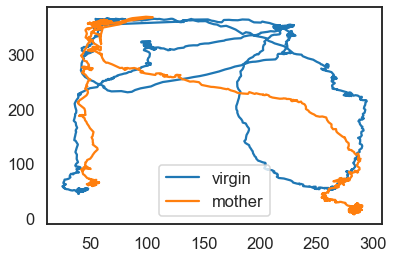

In [16]:
plot_2_mice(traj29[29000:31000])

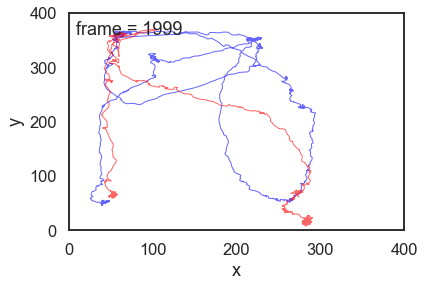

In [21]:
traj_29_for_plot = traj29[29000:31000]

fig = plt.figure()
ax1 = plt.axes(xlim=(0, 400), ylim=(0,400))
plt.xlabel('x')
plt.ylabel('y')

plotlays, plotcols = [2], ["blue","red"]
lines = []
for index in range(2):
    lobj = ax1.plot([],[],lw=1, color=plotcols[index], alpha=0.6)[0]
    lines.append(lobj)

frame_text = ax1.text(0.02, 0.9, '', transform=ax1.transAxes)
z_text = ax1.text(0.02, 0.7, '', transform=ax1.transAxes)

def init():
    for line in lines:
        line.set_data([],[])
    frame_text.set_text('')
    z_text.set_text('')
    return (*lines), frame_text, z_text

x1,y1 = [],[]
x2,y2 = [],[]

frame_num = traj_29_for_plot.shape[0]
#frame_num = 100

def animate(i):
    global x1, y1, x2, y2
    if i % 2000 == 0:
        x1, y1 = [], []
        x2, y2 = [], []
    
    x = traj_29_for_plot[i][0]
    y = traj_29_for_plot[i][1]
    x1.append(x)
    y1.append(y)
    
    x = traj_29_for_plot[i][2]
    y = traj_29_for_plot[i][3]
    x2.append(x)
    y2.append(y)

    xlist = [x1, x2]
    ylist = [y1, y2]
    
    for lnum,line in enumerate(lines):
        line.set_data(xlist[lnum], ylist[lnum]) # set data for each line separately. 
        
    frame_text.set_text('frame = {0:d}'.format(i))
    
    return (*lines), frame_text, z_text

# call the animator.  blit=True means only re-draw the parts that have changed.
anim_groundtruth_with_z = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=frame_num, interval=10, blit=True)
HTML(anim_groundtruth_with_z.to_html5_video())

In [27]:
data = torch.tensor(traj29[29000:31000], dtype=torch.float64)

In [28]:
np.random.seed(10)

torch.manual_seed(10)


tran = LinearTransformation(K=K, d_in=D, d_out=D)
observation = ARSigmoidNormalObservation(K=K, D=D, M=0, transformation=tran, bounds=bounds, alpha=0.5)

model = HMM(K=K, D=D, M=0, observation=observation)


In [29]:
model.log_likelihood(data)

tensor(-41986278.7711, dtype=torch.float64,
       grad_fn=<HMMNormalizerCythonBackward>)

In [30]:
num_iters = 2000
pbar = tqdm(total=num_iters, file=sys.stdout)

optimizer = torch.optim.Adam(model.params, lr=0.005)

losses = []
for i in np.arange(num_iters):

    optimizer.zero_grad()

    loss = model.loss(data)
    loss.backward(retain_graph=True)
    optimizer.step()
    losses.append(loss.detach().numpy())
    
    if i % 10 == 0:
        pbar.set_description('iter {} loss {:.2f}'.format(i, loss))
        pbar.update(10)
        
pbar.close()

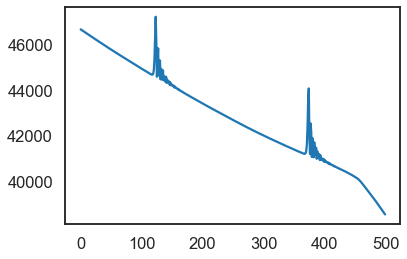

In [32]:
plt.plot(losses[1500:])

In [33]:
num_iters = 2000
pbar = tqdm(total=num_iters, file=sys.stdout)

optimizer = torch.optim.Adam(model.params, lr=0.005)

losses = []
for i in np.arange(num_iters):

    optimizer.zero_grad()

    loss = model.loss(data)
    loss.backward(retain_graph=True)
    optimizer.step()
    losses.append(loss.detach().numpy())
    
    if i % 10 == 0:
        pbar.set_description('iter {} loss {:.2f}'.format(i, loss))
        pbar.update(10)
        
pbar.close()

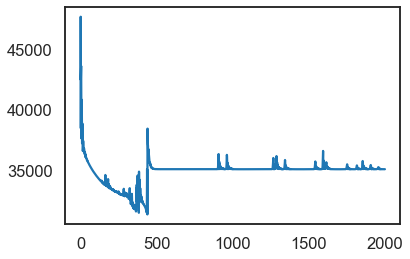

In [35]:
plt.plot(losses[:])

# check prediction

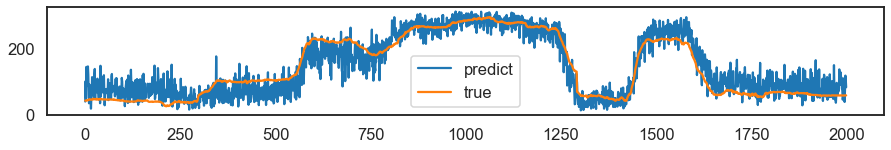

In [36]:
z = model.most_likely_states(data)
x_predict_arr = k_step_prediction(model, z, data)

plt.figure(figsize=(15,2))
plt.plot(x_predict_arr[:,0], label='predict')
plt.plot(data[:,0].numpy(), label='true')
plt.legend()
plt.show()

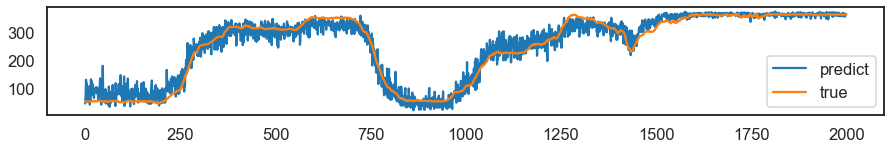

In [37]:
plt.figure(figsize=(15,2))
plt.plot(x_predict_arr[:,1], label='predict')
plt.plot(data[:,1].numpy(), label='true')
plt.legend()
plt.show()

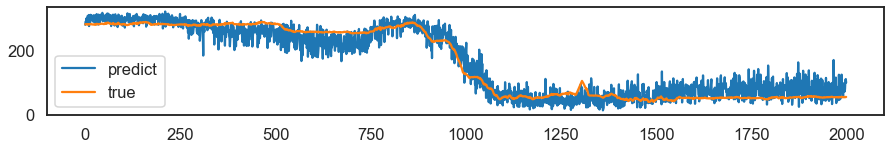

In [38]:
plt.figure(figsize=(15,2))
plt.plot(x_predict_arr[:,2], label='predict')
plt.plot(data[:,2].numpy(), label='true')
plt.legend()
plt.show()

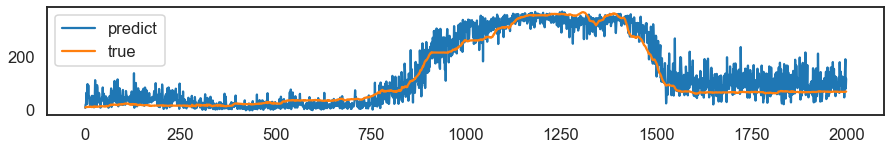

In [39]:
plt.figure(figsize=(15,2))
plt.plot(x_predict_arr[:,3], label='predict')
plt.plot(data[:, 3].numpy(), label='true')
plt.legend()
plt.show()

# check samples

In [63]:
sample_z, sample_x = model.sample(2000)

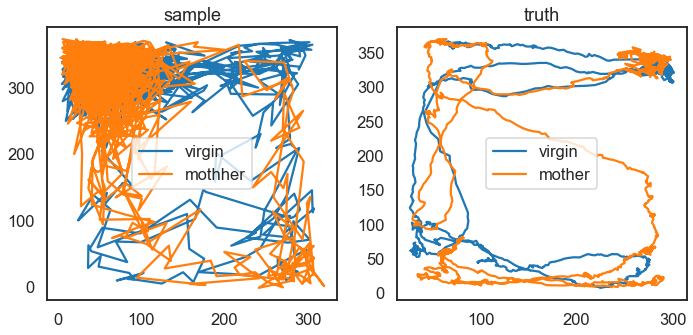

In [64]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(sample_x[:,0], sample_x[:,1], label='virgin')
axs[0].plot(sample_x[:,2], sample_x[:, 3], label='mothher')
axs[0].legend()
axs[0].set_title('sample')

axs[1].plot(traj29[:5000,0], traj29[:5000,1], label='virgin')
axs[1].plot(traj29[:5000,2], traj29[:5000,3], label='mother')
axs[1].legend()
axs[1].set_title('truth')

plt.tight_layout()

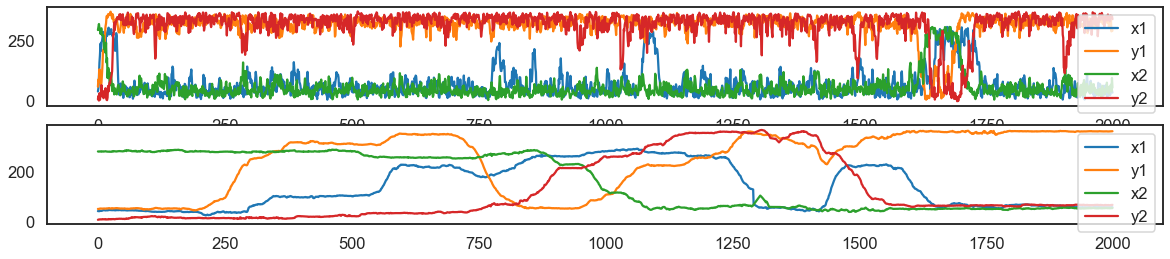

In [65]:
plt.figure(figsize=(20,4))
plt.subplot(2,1,1)
plot_4_traces(sample_x)
plt.subplot(2,1,2)
plot_4_traces(data.numpy())

As the darting behavior is frequent in training data, and the sample trajectories have darting behaviors more often. However, they are not smooth, still.

Let's first try training for more iterations. Then try increasing the lags, or incorporarting the speed (so it can learn smooth transition in the speed).

In [67]:
num_iters = 2000
pbar = tqdm(total=num_iters, file=sys.stdout)

optimizer = torch.optim.Adam(model.params, lr=0.001)

for i in np.arange(num_iters):

    optimizer.zero_grad()

    loss = model.loss(data)
    loss.backward(retain_graph=True)
    optimizer.step()
    losses.append(loss.detach().numpy())
    
    if i % 10 == 0:
        pbar.set_description('iter {} loss {:.2f}'.format(i, loss))
        pbar.update(10)
        
pbar.close()

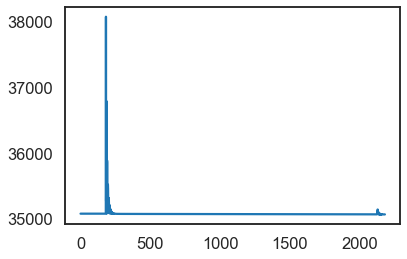

In [69]:
plt.plot(losses[2000:])

Optimization seems to reach convergence.

# Check samples

In [76]:
sample_z, sample_x = model.sample(2000)

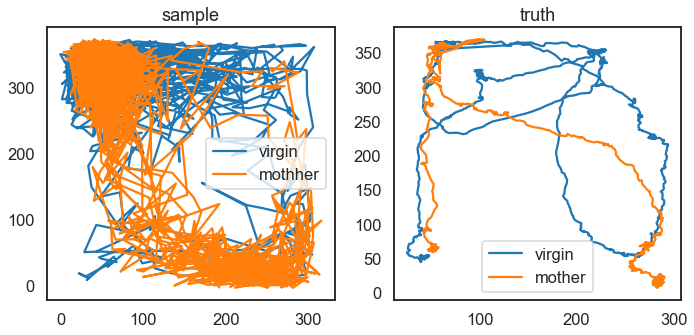

In [77]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(sample_x[:,0], sample_x[:,1], label='virgin')
axs[0].plot(sample_x[:,2], sample_x[:, 3], label='mothher')
axs[0].legend()
axs[0].set_title('sample')

axs[1].plot(data[:,0].numpy(), data[:,1].numpy(), label='virgin')
axs[1].plot(data[:,2].numpy(), data[:,3].numpy(), label='mother')
axs[1].legend()
axs[1].set_title('truth')

plt.tight_layout()

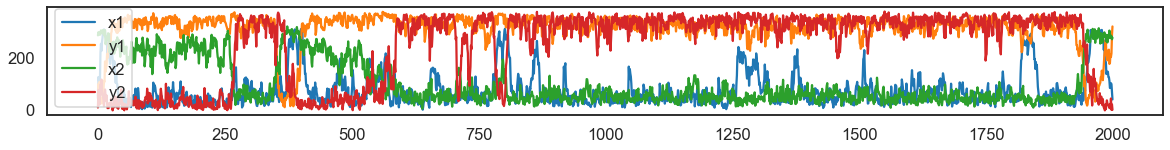

In [103]:
plt.figure(figsize=(20,2))
plot_4_traces(sample_x)

([], <a list of 0 Text yticklabel objects>)

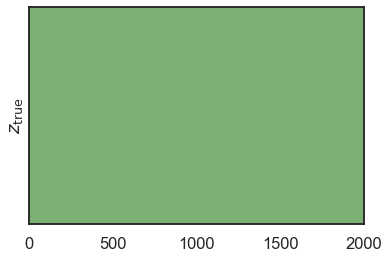

In [79]:
plt.imshow(z[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, data.shape[0])
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

([], <a list of 0 Text yticklabel objects>)

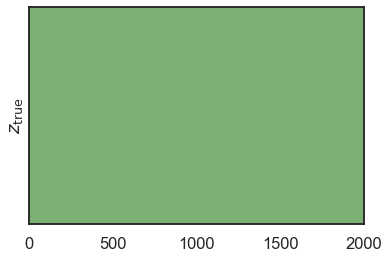

In [80]:
plt.imshow(sample_z[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, data.shape[0])
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

# Try K= 2 (darting and not)

In [82]:
tran2 = LinearTransformation(K=2, d_in=D, d_out=D)
observation2 = ARSigmoidNormalObservation(K=2, D=D, M=0, transformation=tran2, bounds=bounds, alpha=0.5)

model2 = HMM(K=2, D=D, M=0, observation=observation2)


In [83]:
model2.log_likelihood(data)

tensor(-43751407.1701, dtype=torch.float64,
       grad_fn=<HMMNormalizerCythonBackward>)

In [84]:
num_iters = 2000
pbar = tqdm(total=num_iters, file=sys.stdout)

optimizer = torch.optim.Adam(model2.params, lr=0.005)

losses2 = []
for i in np.arange(num_iters):

    optimizer.zero_grad()

    loss2 = model2.loss(data)
    loss2.backward(retain_graph=True)
    optimizer.step()
    losses2.append(loss2.detach().numpy())
    
    if i % 10 == 0:
        pbar.set_description('iter {} loss {:.2f}'.format(i, loss2))
        pbar.update(10)
        
pbar.close()

In [88]:
num_iters = 2000
pbar = tqdm(total=num_iters, file=sys.stdout)

for i in np.arange(num_iters):

    optimizer.zero_grad()

    loss2 = model2.loss(data)
    loss2.backward(retain_graph=True)
    optimizer.step()
    losses2.append(loss2.detach().numpy())
    
    if i % 10 == 0:
        pbar.set_description('iter {} loss {:.2f}'.format(i, loss2))
        pbar.update(10)
        
pbar.close()

# check prediction

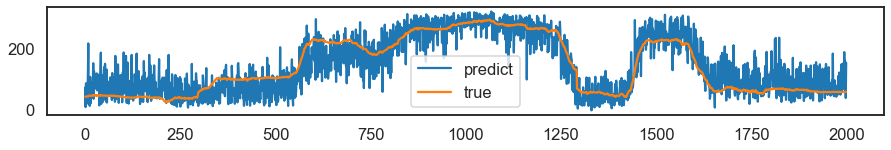

In [91]:
z2 = model2.most_likely_states(data)
x_predict_arr2 = k_step_prediction(model2, z2, data)

plt.figure(figsize=(15,2))
plt.plot(x_predict_arr2[:,0], label='predict')
plt.plot(data[:,0].numpy(), label='true')
plt.legend()
plt.show()

([], <a list of 0 Text yticklabel objects>)

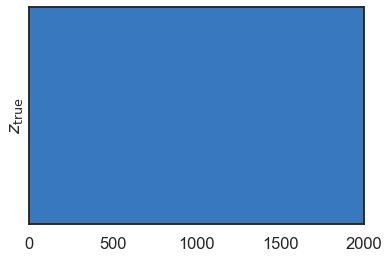

In [92]:
plt.imshow(z2[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, data.shape[0])
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

Still, only one state is being inferred.

In [93]:
model2.transition_matrix

tensor([[9.9972e-01, 2.7890e-04],
        [9.9627e-01, 3.7339e-03]], dtype=torch.float64,
       grad_fn=<SoftmaxBackward>)

In [94]:
model.transition_matrix

tensor([[9.9548e-01, 7.9609e-04, 1.9716e-03, 9.4867e-04, 8.0763e-04],
        [3.4980e-05, 3.8063e-03, 3.6147e-05, 9.9609e-01, 3.5745e-05],
        [3.5201e-03, 1.6047e-03, 9.8705e-01, 4.2732e-03, 3.5530e-03],
        [9.1380e-07, 8.6946e-07, 1.3168e-06, 1.0000e+00, 8.8571e-07],
        [5.3587e-03, 5.6583e-03, 6.0529e-02, 5.8191e-03, 9.2264e-01]],
       dtype=torch.float64, grad_fn=<SoftmaxBackward>)

In [96]:
model.init_dist

tensor([2.4573e-06, 9.9998e-01, 7.7844e-06, 2.5079e-06, 2.5085e-06],
       dtype=torch.float64, grad_fn=<SoftmaxBackward>)

In [97]:
model2.init_dist

tensor([0.8899, 0.1101], dtype=torch.float64, grad_fn=<SoftmaxBackward>)

# check samples

In [171]:
sample_z2, sample_x2 = model2.sample(2000)

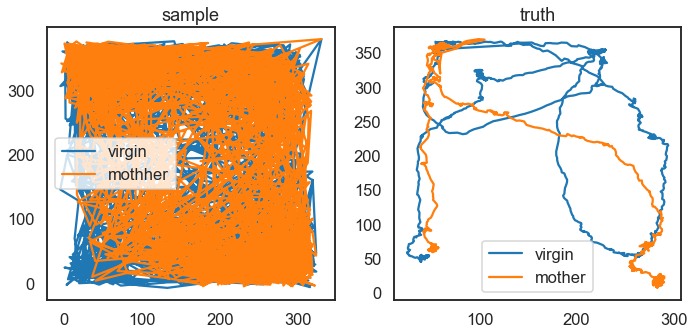

In [172]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(sample_x2[:,0], sample_x2[:,1], label='virgin')
axs[0].plot(sample_x2[:,2], sample_x2[:, 3], label='mothher')
axs[0].legend()
axs[0].set_title('sample')

axs[1].plot(data[:,0].numpy(), data[:,1].numpy(), label='virgin')
axs[1].plot(data[:,2].numpy(), data[:,3].numpy(), label='mother')
axs[1].legend()
axs[1].set_title('truth')

plt.tight_layout()

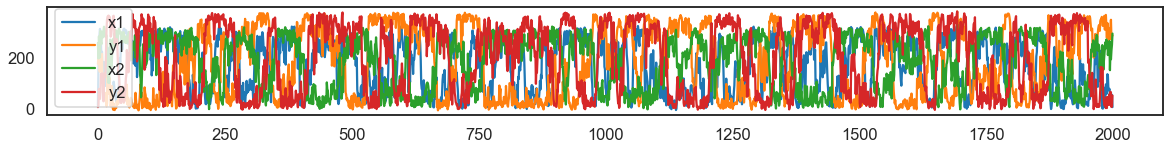

In [162]:
plt.figure(figsize=(20,2))
plot_4_traces(sample_x2)

If we decrease the number of states, it seems that the darting behavior in thhe sample trajectories happens more often.

# now we check the speed

In [163]:
speed = np.diff(data.numpy(), n=1, axis=0)

In [164]:
sample2_speed = np.diff(sample_x2, n=1, axis=0)

## first, distribution

In [134]:
predict_speed = np.diff(x_predict_arr2, n=1, axis=0)

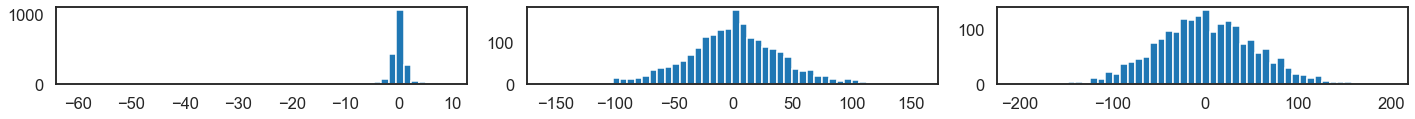

In [138]:
plt.figure(figsize=(20,2))
plt.subplot(1,3,1)
plt.hist(speed[:, 0], bins=50);
plt.subplot(1,3,2)
plt.hist(sample2_speed[:, 0], bins=50);

plt.subplot(1,3,3)
plt.hist(predict_speed[:,0], bins=50);

plt.tight_layout()

In [139]:
acc = np.diff(data.numpy(), n=2, axis=0)
sample2_acc = np.diff(sample_x2, n=2, axis=0)
predict_acc = np.diff(x_predict_arr2, n=2, axis=0)

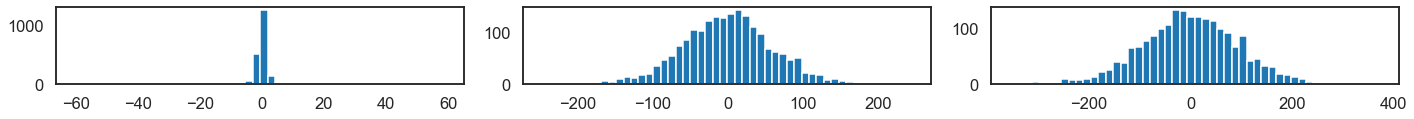

In [142]:
plt.figure(figsize=(20,2))
plt.subplot(1,3,1)
plt.hist(acc[:, 0], bins=50);
plt.subplot(1,3,2)
plt.hist(sample2_acc[:, 0], bins=50);

plt.subplot(1,3,3)
plt.hist(predict_acc[:,0], bins=50);

plt.tight_layout()

## second, check correlation

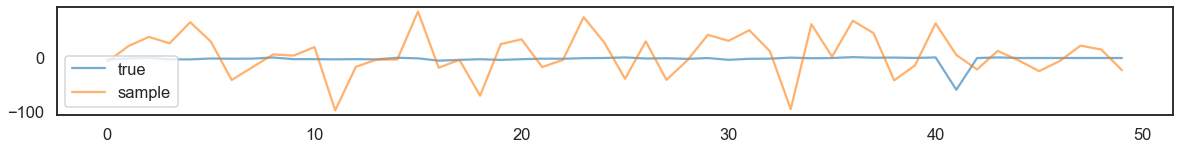

In [165]:
plt.figure(figsize=(20,2))
plt.plot(speed[1250:1300,0], label='true', alpha=0.6)
plt.plot(sample2_speed[1250:1300,0], label='sample', alpha=0.6)
plt.legend()

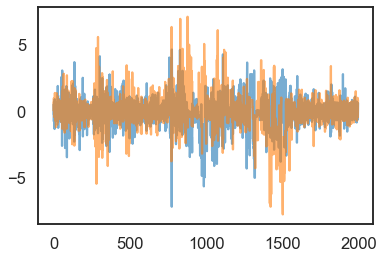

In [157]:
plt.plot(speed[:,2], label='x2', alpha=0.6)
plt.plot(speed[:,3], label='y2', alpha=0.6)

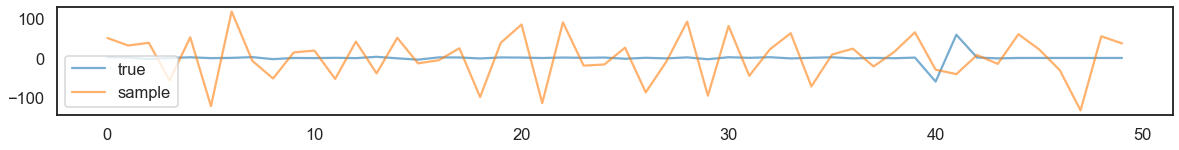

In [166]:
plt.figure(figsize=(20,2))
plt.plot(acc[1250:1300,0], label='true', alpha=0.6)
plt.plot(sample2_acc[1250:1300,0], label='sample', alpha=0.6)
plt.legend()

# try to fit a longer sequence